# Chapter 12: Time Series Analysis

In [99]:
import numpy as np
import pandas as pd
import math
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as smtsa
import matplotlib.pyplot as plt

%matplotlib inline

## Time Series
**Time Series**: a sequence of measurements from a system that varies in time
  * involves a dataset where each value is associated with a *timestamp*, often a series of measurements and the times they were collected
  
Time-series analysis involves the study of *ordered, often temporal data*. Essentially, time-series data are a collection of data points *collected at **constant time intervals***.  

#### Properties
Two properties make time series analysis different from a regression problem:
  1. **Time Dependence**  
  The basic assumption of a *linear regression model* is that observations are independent. This is not the case as prior data impact current/future data observations.
  2. **Seasonality Trends**  
  In addition to *increasing/decreasing **trends**, time series have some form of seasonality trends. They are variations *specific to a particular time frame*.
    * Example: The sales of a wool jacket will invariably have higher sales in winter seasons.

#### Purpose
When relevantly applied, time-series analysis can reveal 
  * long-term **trends**
  * **forecast** future trends

#### Supplementary Links
  1. https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3  
  2. https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
  
### Pandas
Key idea behind using pandas for time series data is that the `index` has to be the variable depicting the date-time information.

### Example: Price of Weed
A political science study on the black market for cannabis in the U.S. collected data from a web site called "Price of Weed" that crowdsources market information by asking participants to report the *price, quantity, quality, and location* of cannabis transactions.

**Goal**: Investigate the effect of policy decisions, like legalization, on markets.

#### Data
Each transaction is *an event in time*, treating this dataset as a time series.

#### Features
  * `city`: string of city name
  * `state`: two-letter state abbreviation
  * `price`: price paid in dollars
  * `amount`: quantity purchased in grams
  * `quality`: high, medium, or low quality, as reported by the purchaser.
  * `date`: date of report, presumed to be shortly after date of purchase
  * `ppg`: price per gram (dollars)
  * `state.name`: string of state name
  * `lat`: approximate latitude of the transaction (based on city name)
  * `lon`: approximate longitude of the transaction  

##### Import Data
`parse_dates` parameter of `pd.read_csv()` interprets the values in column `5` as dates, converting them to NumPy `datetime64` objects.

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


*Note*: The events are not equally spaced in time; the number of transactions reported each day varies from 0 to several hundred. Many methods used to analyze time series require the measurements to be equally spaced. 

#### Grouping Functions
The dataset was divided into groups (*by reported quality*) and then transformed into equally spaced series (*by computing the mean daily price per gram*).

##### Groups
`groupby` is a pandas DataFrame method that returns a `GroupBy` object (groups). It's used in a for loop, iterating the *names of the groups* and the *DataFrames* that represent them.

**Groups**:
The values of `quality` are `low`, `medium`, & `high`. Thus, there are 3 groups.
1. `low`
2. `medium`
3. `high`

##### `GroupByQualityAndDay` Function
**Parameter: `transactions`**
`transactions` is a DataFrame that was indexed to contain the columns: `date` & `ppg`. These 2 columns are then grouped by `date` using the `groupby` method.

The result is `grouped`, mapping each date to a DataFrame that contains the prices reported on *that date*.

**Method: `aggregrate`**
`aggregrate` is a `GroupBy` method that iterates through the groups and applies a function to each of the column (*in this case only `ppg`*).

##### `GroupByDay` Function
For some of the analyses, it is more convenient to work with time in more "human-friendly" units (e.g. `years`).  
`GroupByDay` function adds a column named `date` that stores the number of years since the first transaction as a float.

Thus, resulting DataFrame has columns: `ppg`, `date`, & `years`.

In [3]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    groups = transactions[['date', 'ppg']].groupby('date')
    daily = groups.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily


def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

#### `GroupByDay` Function

In [4]:
transactions[transactions.date == '2010-09-02'].ppg.mean()

11.727733333333333

In [5]:
transactions[transactions.date == '2010-09-02'].shape

(75, 10)

Group by date (obtain count for each group/date).

In [6]:
transactions[['date', 'ppg']].groupby('date').size().head()

date
2010-09-02     75
2010-09-03    287
2010-09-04      8
2010-09-05      6
2010-09-06      4
dtype: int64

Apply aggregate function (`np.mean`) on each group.

In [23]:
transactions[['date', 'ppg']].groupby('date').agg(np.mean).head()

,ppg
date,
2010-09-02,11.727733
2010-09-03,11.972892
2010-09-04,13.752500
2010-09-05,15.113333
2010-09-06,15.537500


In [24]:
# transactions[['date', 'ppg']].groupby('date')
GroupByDay(transactions).head()

,ppg,date,years
date,,,
2010-09-02,11.727733,2010-09-02,0.000000
2010-09-03,11.972892,2010-09-03,0.002738
2010-09-04,13.752500,2010-09-04,0.005476
2010-09-05,15.113333,2010-09-05,0.008214
2010-09-06,15.537500,2010-09-06,0.010952


#### `GroupByQualityAndDay` Function
A map from each quality (`low`, `medium`, `high`) to a DataFrame of daily prices (`ppg`).

In [25]:
dailies = GroupByQualityAndDay(transactions)
hi_qual = dailies['high']
med_qual = dailies['medium']
low_qual = dailies['low']

## Plot
Time series of daily price per gram for **high, medium,** & **low** quality cannabis. 

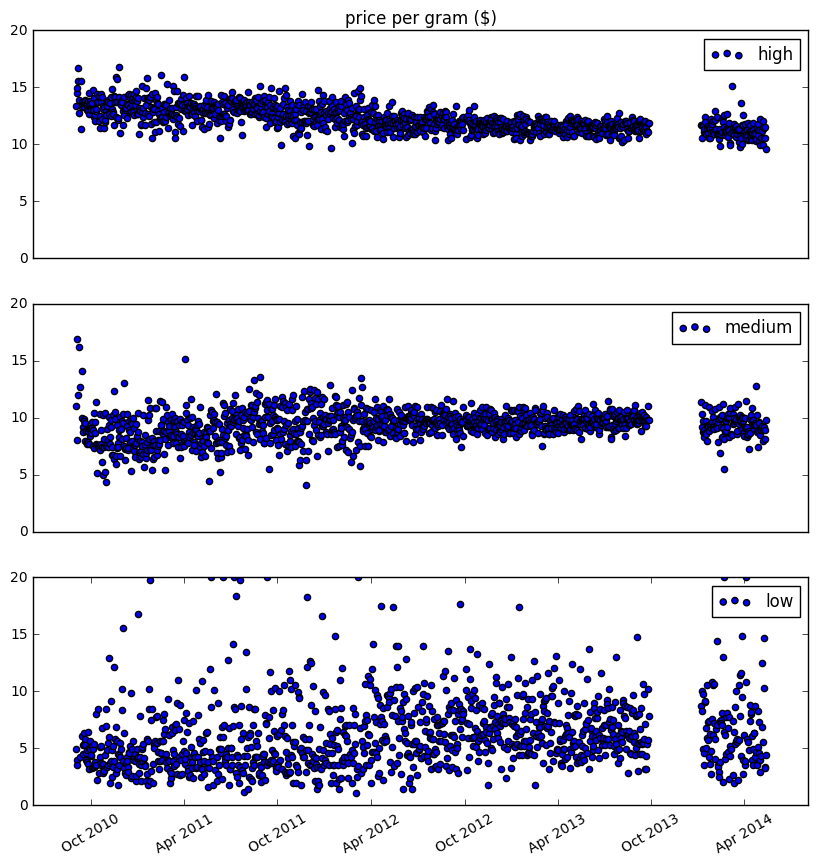

In [10]:
plt.figure(figsize=(10, 10))
for i, (name, daily) in enumerate(dailies.items()):
    plt.subplot(3, 1, i+1)
    plt.scatter(daily.index, daily.ppg, label=name)
    title = 'price per gram ($)' if i == 0 else ''
    plt.title(title)
    if i==2:
        plt.xticks(rotation=30)
    else:
        plt.xticks([]) # empty x label
    plt.legend(loc='upper right')
    plt.ylim([0, 20])
plt.show()

**Missing Data**: Gap around November 2013 hinting that data collection was not active during this time or is not available.

#### Interpretations
The price (`ppg`) of *high* quality cannabis is declining and *medium* quality cannabis `ppg` is increasing towards the end of the time periods.

The price of *low* quality might be increasing, but it's harder to tell from the plot due to its volatility.

## Characterize Trends from Time Series Data
Determine the stationarity of the time series, *whether a trend exists or not*?

### Stationarity of Time Series
A time series is said to be *stationary* if its statistical properties (e.g. mean & variance) remain **constant over time**. In other words, **no trend exist**. 

#### Stationarity Criteria
  1. constant **mean**
  2. constant **variance**
  3. autocovariance independent of time

Most time series models work on the assumption that the time series is stationary. Intuitively, if a time series has a particular behavior/trend over time, there's a high probability that ti will follow the same trend in the future.

#### Practicality of Stationarity Assumption
Although this stationarity assumption is taken in models, almost none of practical time series are stationary. 2 major reasons exists to why time series are predominatly **non-stationary** and have a trend:

 1. **Trend**: varying mean over time
 2. **Seasonality**: variations at specific time-frames
 
Underlying principle is to model or estimate the *trend* & *seasonality* inherent in the time series and then removing them from the series to obtain a *stationary series*. Afterwards, statistical forecasting techniques can be implemented on the series for predicitons. The final step would be to convert the forecasted values into the original scale by applying trend & seasonality constraints.

### Approaches
Model to extract a *trend* from a series.
  1. Linear Regression: *simple* data
  2. Rolling Mean: *non-simple* data


### Linear Regression

In [11]:
def RunLinearModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

In [12]:
quality = []
intercept = []
slope = []
r2 = []
for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    quality += [name]
    intercept += [results.params['Intercept']]
    slope += [results.params['years']]
    r2 += [results.rsquared]
    
pd.concat([pd.Series(quality, name='quality'), pd.Series(intercept, name='intercept'),
           pd.Series(slope, name='slope'), pd.Series(r2, name='R2')],
         axis=1)

,quality,intercept,slope,R2
0,high,13.449644,-0.708207,0.444078
1,medium,8.879130,0.283193,0.049905
2,low,5.361599,0.568345,0.029596


#### Interpretation
***Slope***
  * estimated slope of `high` quality cannabis shows that its price drops by 71 cents per year during the observed interval
  * `medium` quality cannabis' price increases by 28 cents per year
  * `low` quality cannabis' price increases by 57 cents per year


***R<sup>2</sup>***
  * `high` quality cannabis has 0.44 R<sup>2</sup>, meaning that `time` as an *explanatory* variable accounts for 44% of the observed variability in price (`ppg`)
  * `medium` & `low` quality cannabis have a smaller change in price and higher variability. Thus, R<sup>2</sup> are smaller.

All slopes and R<sup>2</sup> values are *statistically significant* with very small **p-values**.

### Plot Linear Regression: `high` Quality Cannabis

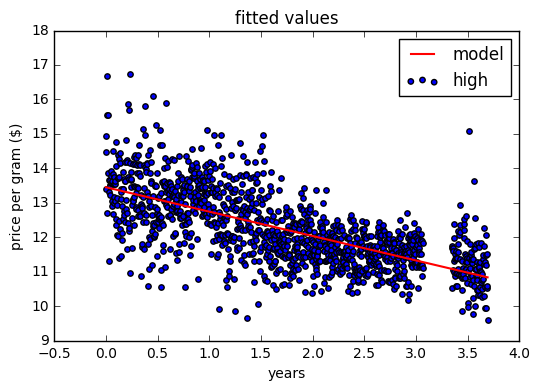

In [13]:
model, results = RunLinearModel(dailies['high'])
years = model.exog[:, 1]
values = model. endog # ppg
plt.scatter(years, values, s=15, label='high')
plt.plot(years, results.fittedvalues, c='r', linewidth=1.5, 
         label='model')
plt.xlabel('years')
plt.ylabel('price per gram ($)')
plt.title('fitted values')
plt.legend(loc='upper right')
plt.show()

##### Drawbacks
Linear regression cannot extract *trends* from non-simple data.  

#### Conclusion
Linear regression is not the most appropriate model for this data:
  1. No reason to expect the long-term trend to be a *line* or any other simple function. In general, prices are determined by **supply and demand**, both of which vary over time in unpredictable ways.
  2. Linear regression model gives equal weight to all data (recent and past). For purposes of prediction, more weight should be given to recent datra
  3. One of the assumptions of Linear regression is that the residuals are **uncorrelated noise**.
    * With time series data, the assumption is often *false* because successive values are correlated.

### Time Series Modeling Assumptions
Most time series analysis is based on the *modeling assumption* that the observed series is the sum of 3 components:
  1. **Trend**: a smooth function that captures persistent changes
  2. **Seasonality**: periodic variation, possibly including daily, weekly, monthly, or yearly cycles
  3. **Noise**: random variation around the long-term trend

**Moving averages** is a good alternative to extract trends that are not a simple function.

### Moving Averages
Moving average is one of several stratistics intended to estimate the underlying trend in a time series by computing averages (of some kind) for a series of overlapping windows.

A moving average 
  1. divides the series into overlapping regions (**windows**)
  2. computes the average of the values in each window.
 
**Types**:
  * **Rolling Mean**: a moving average based on the mean value in each window
  * **Exponentially-Weighted Moving Average (EWMA)**: a moving average based on a weighted mean that gives the *highest* weight to the most recent values, and *exponentially decreasing weights* to earlier values

#### Rolling Mean
One of the simplest moving averages, calculating the mean in each *window*.

It does a good job of *smoothing out the noise* and *extracting the trend*.

*Example*: If a window size is **3**, the rolling mean computes the mean of values `0-2`, `1-3`, `2-4`, ...

In [14]:
series = np.arange(10)
print series

pd.rolling_mean(series, 3)

[0 1 2 3 4 5 6 7 8 9]


/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


array([ nan,  nan,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.])

**`window` - 1** = `nan` values

The first 2 (`3-1`) values are `nan`. The next value is the mean of the 1st three elements (0, 1, & 2). The next value is the mean of 1, 2, & 3. And so on.

##### Handle Missing Data
Before `pd.rolling_mean` can be applied to the cannabis data, the *missing data* must be dealt with. The previous dates with missing data were simply omitted/dropped.
  * There are some days in the observed interval with no reported transactions for one  or more quality categories, and a period in 2013 when data collection was not active.

In [15]:
daily = dailies['high']
daily.head()

,ppg,date,years
date,,,
2010-09-02,13.384186,2010-09-02,0.000000
2010-09-03,14.459588,2010-09-03,0.002738
2010-09-04,14.923333,2010-09-04,0.005476
2010-09-05,16.667500,2010-09-05,0.008214
2010-09-06,15.537500,2010-09-06,0.010952


1) Compute a date range that includes every day from the start to the end of the observed interval

In [16]:
dates = pd.date_range(daily.index.min(), daily.index.max())

2) Represent the missing data explicitly by reindexing the DataFrame.  A New DataFrame is created with all of the data from `daily`, but including rows for all dates wfilled with `nan`.

In [17]:
reindexed = daily.reindex(dates)
reindexed.head()

,ppg,date,years
2010-09-02,13.384186,2010-09-02,0.000000
2010-09-03,14.459588,2010-09-03,0.002738
2010-09-04,14.923333,2010-09-04,0.005476
2010-09-05,16.667500,2010-09-05,0.008214
2010-09-06,15.537500,2010-09-06,0.010952


##### Compute Rolling Mean
Compute the rolling mean with a window size of 30. So each value in `roll_mean` is the mean of 30 values from `reindexed.ppg`.

The first 29 values are `nan` and wherever there's a missing value, it's followed by another 29 `nans`. There are ways to fill these gaps, but they're a minor nuisance.

In [18]:
roll_mean = pd.rolling_mean(reindexed.ppg, 30)
roll_mean.head()

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  if __name__ == '__main__':


2010-09-02   NaN
2010-09-03   NaN
2010-09-04   NaN
2010-09-05   NaN
2010-09-06   NaN
Freq: D, Name: ppg, dtype: float64

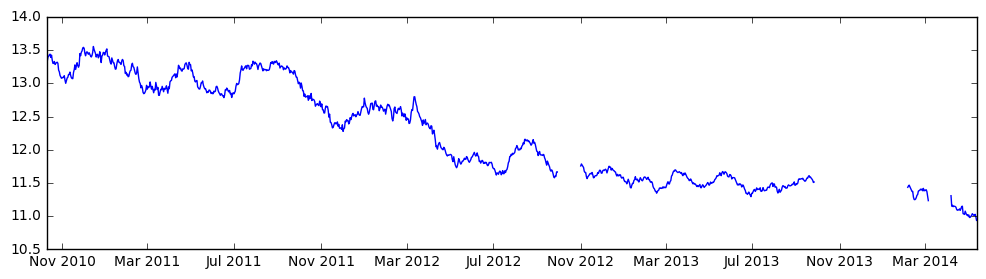

In [19]:
plt.figure(figsize=(12,3))
plt.plot(roll_mean.index, roll_mean)
plt.show()

#### Exponentially-Weighted Moving Average (EWMA)
Computes the *weighted average* where 
  * the **most recent** value has the *highest* weight
  * weights for the **previous** values drop off exponentially
  
`pd.ewma` also handles missing values better.

##### Compute EWMA
`pd.ewma`'s **`span`** parameter corresponds roughly to the *window size* of a moving average. It controls how fast the weights drop off, determining the number of points that make a non-negligible contribution to each average.

In [20]:
ewma = pd.ewma(reindexed.ppg, span = 30)
ewma.head()

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


2010-09-02    13.384186
2010-09-03    13.939810
2010-09-04    14.289742
2010-09-05    14.944901
2010-09-06    15.079732
Freq: D, Name: ppg, dtype: float64

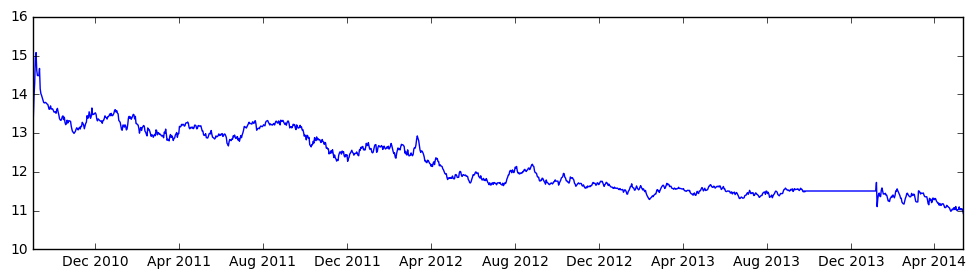

In [21]:
plt.figure(figsize=(12, 3))
plt.plot(ewma.index, ewma)
plt.show()

#### Rolling Mean vs. EWMA
EWMA and rolling mean are similar *where they are both defined*, but EWMA has no missing values. Thus, making it easier to work with.

The values of EWMA are noisy at the beginning of the time series but this is because they are based on *fewer* data points.

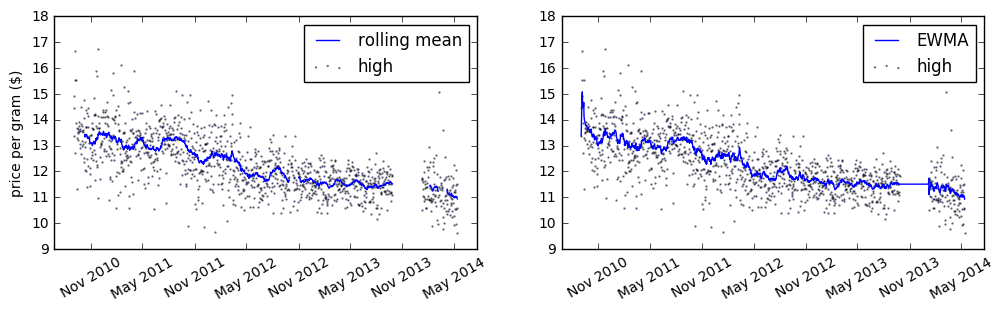

In [22]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(roll_mean.index, roll_mean, label='rolling mean')
plt.scatter(daily.index, daily.ppg, label='high', s=0.5, alpha=0.5)
plt.ylabel('price per gram ($)')
plt.xticks(rotation=30)
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.plot(ewma.index, ewma, label='EWMA')
plt.scatter(daily.index, daily.ppg, label='high', s=0.5, alpha=0.5)
plt.xticks(rotation=30)
plt.legend(loc='upper right')
plt.show()

## Missing Values
After characterizing the trend of the time series, the next step is to investigate **seasonality**, *which is periodic behavior*. Methods for these steps work well with missing data.

### Method: *Missing Average*
A simple and common way to fill missing data is to use a moving average. The Series method `pd.Series.fillna()` does this.

Wherever reindexed.ppg is `nan`, the method replaces it with the corresponding value from `ewma`.

Essentially, **resampling** is used to generate missing values with the right amount of noise.

In [26]:
reindexed.ppg.fillna(ewma, inplace=True)

##### Drawback
This approach understates the noise in the series. This can be solved by adding in resampled residuals.

1. `resid` contains the residual values, not including days when `ppg` is `nan`.
2. `fake_data` contains the sum of the movinga verage and a random sample of residuals.
3. `fillna` replaces `nan` with values from `fake_data`.

In [37]:
resid = (reindexed.ppg - ewma).dropna() # residuals + drop null
resample = np.random.choice(resid, len(reindexed), replace=True)

fake_data = ewma + resample
reindexed.ppg.fillna(fake_data, inplace=True)

2010-09-02    13.384186
2010-09-03    13.939810
2010-09-04    14.289742
2010-09-05    14.944901
2010-09-06    15.079732
Freq: D, Name: ppg, dtype: float64

In [41]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.ewma(reindexed.ppg, span=span)

    resid = (reindexed.ppg - ewma).dropna()
    resample = np.random.choice(resid, len(reindexed), replace=True)

    fake_data = ewma + resample
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

In [44]:
filled = FillMissing(daily)
filled.head()

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()


,ppg,date,years,ewma,resid
2010-09-02,13.384186,2010-09-02,0.000000,13.384186,0.000000
2010-09-03,14.459588,2010-09-03,0.002738,13.939810,0.519777
2010-09-04,14.923333,2010-09-04,0.005476,14.289742,0.633591
2010-09-05,16.667500,2010-09-05,0.008214,14.944901,1.722599
2010-09-06,15.537500,2010-09-06,0.010952,15.079732,0.457768


##### Result
The filled data is visually similar to the actual values. Since the resampled residuals are random, the reuslts are different everytime. 

Later this error created by missing values is characterized.

Plot daily prices (EWMA and filled data).

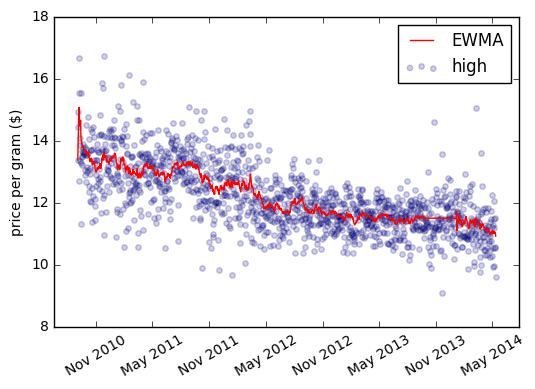

In [48]:
plt.plot(filled.index, filled.ewma, label='EWMA', c='r')
plt.scatter(filled.index, filled.ppg, label='high', s=15, alpha=0.2)
plt.ylabel('price per gram ($)')
plt.xticks(rotation=30)
plt.legend(loc='upper right')


# Investigate Seasonality
After characterizing the trend of the time series, the next step is to investigate **seasonality**, *which is periodic behavior*.
  * Time series data based on human behavior often exhibit *daily, weekly, monthly, or yearly cycles*.

## Serial Correlation
**Serial Correlation**: correlation between a time series and a shifted or lagged version of itself.
  * it is a pattern where each value *is correlated with the next one* in the series

**Lag**: the size of the sift in a serial correlation or autocorrelation.  

*Example:* As prices vary from day to day, you might expect to see patterns:
  * If the price is *high* on Monday, you might expect it to be high for a few more days
  * If it's *low*, you might expect it to stay low

### Computation
To compute serial correlation:
  1. shift the time series by an interval called **lag**
  2. compute the correlation of the shifted series with the original
  
#### Method 1: `SerialCorr` Function
Computes seril correlation with the given lag.

In [66]:
def Var(xs, mu=None, ddof=0):
    """Computes variance.

    xs: sequence of values
    mu: option known mean
    ddof: delta degrees of freedom

    returns: float
    """
    xs = np.asarray(xs)

    if mu is None:
        mu = xs.mean()

    ds = xs - mu
    return np.dot(ds, ds) / (len(xs) - ddof)


def MeanVar(xs, ddof=0):
    """Computes mean and variance.

    Based on http://stackoverflow.com/questions/19391149/
    numpy-mean-and-variance-from-single-function

    xs: sequence of values
    ddof: delta degrees of freedom
    
    returns: pair of float, mean and var
    """
    xs = np.asarray(xs)
    mean = xs.mean()
    s2 = Var(xs, mean, ddof)
    return mean, s2


def Cov(xs, ys, meanx=None, meany=None):
    """Computes Cov(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values
        meanx: optional float mean of xs
        meany: optional float mean of ys

    Returns:
        Cov(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov


def Corr(xs, ys):
    """Computes Corr(X, Y).

    Args:
        xs: sequence of values
        ys: sequence of values

    Returns:
        Corr(X, Y)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = MeanVar(xs)
    meany, vary = MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / math.sqrt(varx * vary)

    return corr


def SerialCorr(series, lag=1):
    """Computes the serial correlation of a series.

    series: Series
    lag: integer number of intervals to shift

    returns: float correlation
    """
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = Corr(xs, ys)
    return corr

After the shift, the first `lag` values are `nan`, so they are removed using a slice before computing `Corr` in `SerialCorr` function.



Before computing correlations, we'll fill missing values.

In [79]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

/home/cpnguyen/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=30,min_periods=0,adjust=True).mean()


Serial Correlations for raw price data.

In [80]:
for name, filled in filled_dailies.items():            
    corr = SerialCorr(filled.ppg, lag=1)
    print name, corr

high 0.479433272826
medium 0.175249445362
low 0.117864130008


#### Method 2: `pandas.Series.autocorr(lag=1)`
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html

Lag-N auto correlation


In [81]:
for name, filled in filled_dailies.items():
    corr = filled['ppg'].autocorr(lag=1)
    print name, corr

high 0.479433272826
medium 0.175249445362
low 0.117864130008


Applying Serial Correlation to the raw price data with a lag 1, it's found that serial correlation 0.48 for `high` quality category, 0.16 for `medium` and 0.10 for `low`.

In any time series with long-term tredn, we expect to see strong serial correlations. For example, if prices are falling, we expect to see:
  * `values > mean` in the *first half* of the series
  * `values < mean` in the *second half*

##### Persistence of Serial Correlation
It's more interesting to see if the correlation persists *if you subtract away the trend*.

For example, we can compute the residual of the `EWMA` and then compute its serial correlation.

In [82]:
# ewma = pandas.ewma(reindexed.ppg, span=30)
# resid = reindexed.ppg - ewma
# corr = SerialCorr(resid, 1)

for name, filled in filled_dailies.items():            
    corr = filled.resid.autocorr(lag=1)
    print name, corr

high -0.01186734992
medium -0.015891123893
low 0.048213010928


With a `lag=1`, the serial correlations for the *de-trended* data are -0.012 for `high` quality, -0.015 for `medium` and 0.04 for `low`.

These values are small, indicating that there is little or no on-eday serial correlation in this series.

Even if the correlations between consecutive days are weak, there might be correlations across intervals of one week, one month, or one year. To check for *weekly, monthly, and yearly seasonality*, just run the analysis with different lags:

In [97]:
rows = []
for lag in [1, 7, 30, 365]:
    print 'lag=', lag
    for name, filled in filled_dailies.items():            
        corr = filled.resid.autocorr(lag=lag)
        print name, '\t %.3f' % corr
    print '\n'

lag= 1
high 	 -0.012
medium 	 -0.016
low 	 0.048


lag= 7
high 	 0.009
medium 	 -0.042
low 	 -0.009


lag= 30
high 	 0.007
medium 	 -0.002
low 	 -0.021


lag= 365
high 	 0.057
medium 	 0.011
low 	 0.034




The strongest correlation is a weekly cycle in the medium quality category.

## Autocorrelation
**Autocorrelation**: a more general term for a serial correlation with *any amount of lag*.  
  * Test whether *serial correlations* are statistically significant

### Autocorrelation Function
**Autocorrelation Function**: a function that maps from lag to serial correlation with the given lag.
  * it's another name for *serial correlation* used more often when the **lag is not 1**
  * used to test all lags, when you think a series might have some serial correlation but *don't know which lags to test*

#### Method: StatsModels Package `smtsa.acf()` Function
http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.acf.html

`statsmodels.tsa.stattools.acf()`

`afc` computes serial correlations with lags from 0 through `nlags`. The `unbiased` parameter tells `acf` to correct the estimates for the sample size.

**Results**: array of correlations

#### Example: Daily Prices for `High` Quality with Correlations for lags 1, 7, 30, & 365
Confirm that **serial correlation** and **autocorrelation** yield the same results for the same given `lag`.

*Note*: With `lag=0`, `acf` computes the correlation of the series with itself, which is always 1.

In [108]:
acf = smtsa.acf(filled_dailies['high'].resid, nlags=365, unbiased=True)

print "high quality:"
print "lag = 0: \t\t %.3f" % acf[0]
print "lag = 1 (day): \t\t %.3f" % acf[1]
print "lag = 7 (week): \t %.3f" % acf[7]
print "lag = 30 (month): \t %.3f" % acf[30]
print "lag = 365 (year): \t %.3f" % acf[365]

high quality:
lag = 0: 		 1.000
lag = 1 (day): 		 -0.012
lag = 7 (week): 	 0.009
lag = 30 (month): 	 0.007
lag = 365 (year): 	 0.055


### Example: Autocorrelation for 3 Quality of Cannabis with `nlags=40`
Plot autocorrelation functions for the 3 quality categories with `nlags=40`. 

The region -0.05 < y < 0.05 shows the normal variability expected *if there is no actual autocorrelation*. Anything that falls **outside this range** is *statistically significant*, with a **p-value** < 0.05. 

##### False Positive Rate
Since the *false positive rate* is 5%, we are computing 120 correlations (40 lags for each of the 3 time series/qualities), we'd expect to see about **6 points outside of this region**.

In fact, there are actually 9.

##### Conclusion
It's concluded that there are **no autocorrelations** in these series that could *NOT* be explained by chance.

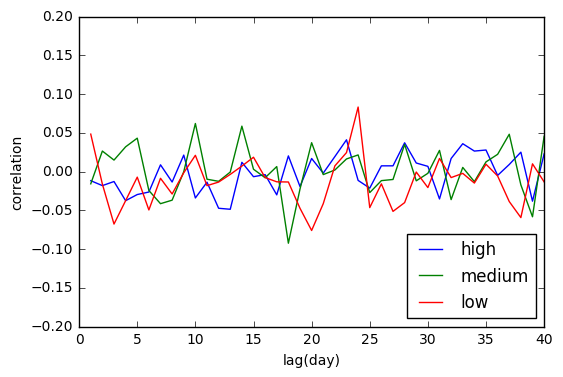

In [142]:
# slice to ignore first autocorrelation of 1.0
acf40_h = smtsa.acf(filled_dailies['high'].resid, nlags=40, unbiased=True)[1:]
acf40_m = smtsa.acf(filled_dailies['medium'].resid, nlags=40, unbiased=True)[1:]
acf40_l = smtsa.acf(filled_dailies['low'].resid, nlags=40, unbiased=True)[1:]

# lag 1-40
lag40 = range(41)[1:]

fig = plt.figure()
plt.plot(lag40, acf40_h, label='high')
plt.plot(lag40, acf40_m, label='medium')
plt.plot(lag40, acf40_l, label='low')
plt.xlabel('lag(day)')
plt.ylabel('correlation')
plt.ylim([-0.20,0.20])
plt.legend(loc='lower right')

In [143]:
df_40h = pd.Series(acf40_h, name='high')
ss_40h = len(df_40h[df_40h < - 0.05]) + len(df_40h[df_40h > 0.05])

df_40m = pd.Series(acf40_m, name='med')
ss_40m  = len(df_40m[df_40m < - 0.05]) + len(df_40m[df_40m > 0.05])

df_40l = pd.Series(acf40_l, name='low')
ss_40l  = len(df_40l[df_40l < - 0.05]) + len(df_40l[df_40l > 0.05])

ss_40h + ss_40m + ss_40l

9

## Prediction
Time series analysis can be used to investigate and sometimes explain the **behavior of systems** that vary in time. It can also make predictions.

### Linear Regression
The fitted *Linear Regression* model used to extract the trends from time series may also be used for predictions. It contains a `predict` method.

In [145]:
def GenerateSimplePrediction(results, years):
    """Generates a simple prediction.

    results: results object
    years: sequence of times (in years) to make predictions for

    returns: sequence of predicted values
    """
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

Variables:
  * **`results`**: linear regression model's (`ols`) results object
  * **`years`**: sequence of time values we want predictions for
  * **`predict`**: result of predictions for each time value in `years`

In [159]:
daily_hi = dailies['high']
high_model, high_results = RunLinearModel(daily_hi)
years = np.linspace(0, 5, 11)
predict = GenerateSimplePrediction(high_results, years)
predict # price per gram (ppg) for given time

array([ 13.44964431,  13.09554105,  12.74143779,  12.38733454,
        12.03323128,  11.67912802,  11.32502476,  10.9709215 ,
        10.61681824,  10.26271498,   9.90861172])

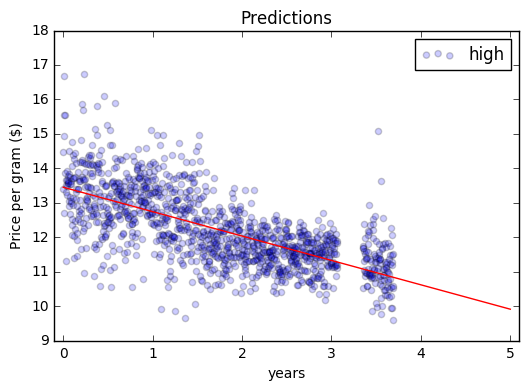

In [165]:
plt.scatter(daily_hi.years, daily_hi.ppg, alpha=0.2, label='high')
plt.plot(years, predict, color='r')
plt.xlim([years[0]-0.1, years[-1]+0.1])
plt.xlabel('years')
plt.ylabel('Price per gram ($)')
plt.legend(loc='upper right')
plt.title('Predictions')
plt.show()

### Errors
When we generate predictions, we want to quatify the uncertainty in the prediction. We can do that by resampling.

3 sources of errors:
  1. **Sampling Error**
  2. **Random Variation**
  3. **Modeling Error**
  
*Note*: **Unexpected Future Events** and **Modeling Errors** are difficult to qunatify.
  
##### Sampling Error
The prediction based  on estimated parameters, which depend on random vairation in the sample. If we run the experiment again, we expect the estimates to vary.

##### Random Variation
Even if the estimated parameters are perfect, the observed data varies randomly around the long-term trend, and we expect this variation to continue in the future.

##### Modeling Error
We have already seen evidence that the long-term trend is not linear, so predictions based on a linear model will eventually fail.

##### Other Considerations: *Unexpected Future Events Error*
Another source of error warranting consideratiion as future events cannot be foreseen. For example, agricultural prices are affected by weather. Also, all rices are affected by politics and law.

### Uncertainty: Quantification of *Sampling Error* and *Prediction Error*
##### `SimulateResults` Function
The following function fits a model to the data, computes residuals, then resamples from the residuals to general fake datasets. It fits the same model to each fake dataset and returns a list of results.

Example shows *predictions based on linear fits, showing **variation due to Sampling Error & Prediction Error***.

#### Model
The regression model is based on the assumption that the system is **stationary**, where parameters of the model don't change over the time. More specifically, *slope* and *intercept* are constant as well as the residuals' distribution.
  * **Stationary**: a model is stationary if the parameters and the distribution of residuals does not change over time.

In [182]:
def SimulateResults(daily, iters=101):
    """Run simulations based on resampling residuals.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    import thinkstats2
    
    _, results = RunLinearModel(daily)
    fake = daily.copy()

    result_seq = []
    for _ in range(iters):
        fake.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        _, fake_results = RunLinearModel(fake)
        result_seq.append(fake_results)

    return result_seq

To generate predictions, we take the list of results fitted to resampled data.  For each model, we use the `predict` method to generate predictions, and return a sequence of predictions.

If `add_resid` is true, we add resampled residuals to the predicted values, which generates predictions that include predictive uncertainty (due to random noise) as well as modeling uncertainty (due to random sampling).

In [178]:
def GeneratePredictions(result_seq, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.

    When add_resid is False, predictions represent sampling error only.

    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    
    result_seq: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals

    returns: sequence of predictions
    """
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pd.DataFrame(d)
    
    predict_seq = []
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)

    return predict_seq


def PlotPredictions(daily, years, iters=101, percent=90):
    """Plots predictions.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateResults(daily, iters=iters)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')

    predict_seq = GeneratePredictions(result_seq, years, add_resid=False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

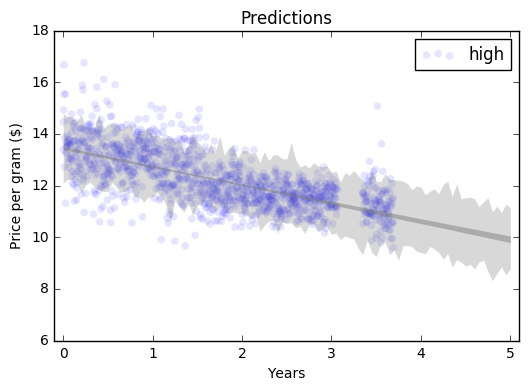

In [181]:
import thinkplot 
import thinkstats2

years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily_hi.years, daily_hi.ppg, alpha=0.1, label='high')
PlotPredictions(daily_hi, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

#### Quantification of Sampling & Prediction Errors

The *darker* region that quantifies **modeling uncertainty**, representing a 90% confidence interval for **Sampling error**. That is, uncertainty about the *estimated slope & intercept* due to sampling.


The *lighter* region that quantifies **predictive uncertainty**, represneting 90% confidence interval for **Prediction Error**, which is the *sum of sampling error and random variation*.

### Uncertainty: *How much past data should we use to build the model?*
`SimulateIntervals` function generates a sequence of models based on different amounts of past data. `PlotIntervals` plots the results.

In [183]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq


def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')

#### Example: `High` Quality Category
Plot of `high` quality category when taking into account uncertainty about how much past data to use.

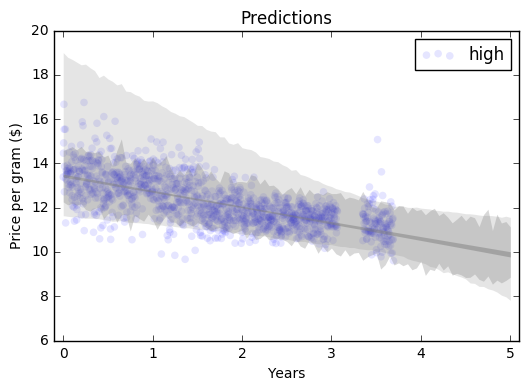

In [185]:
thinkplot.Scatter(daily_hi.years, daily_hi.ppg, alpha=0.1, label='high')
PlotIntervals(daily_hi, years)
PlotPredictions(daily_hi, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)')

## Further Reading
Time series analysis is a big topic. This chapter has only scratched the surface.

Potential Future Topics:
  1. **Autoregression**: an important tool for working with time series data
  
### Hints
1. Use `.fillna()` to fill in missing values *before running time series analysis*. This way the time between consecutive elements is consistent.
2. Use `Series.diff` to compute differences between *successive* elements
3. Use `.reindex` to extend the DataFrame index into the futre.
4. Use `.fillna()` to put your predicted valeus into the DataFrame.